# Predict Bike Sharing Demand with AutoGluon Template

### Install packages

In [3]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

  Using cached pip-22.1.2-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.2 MB/s eta 0:00:00:00:0100:01
  Using cached wheel-0.37.1-py2.py3-none-any.whl (35 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.4.0
    Uninstalling setuptools-59.4.0:
      Successfully uninstalled setuptools-59.4.0
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
  Using cached bokeh-2.0.1-py3-none-any.whl
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.4.2
    Uninstalling bokeh-2.4.2:
      Successfully uninstalled bokeh-2.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.1/203.1 kB 146.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 167.2

### Download dataset

### Setup Kaggle API Key


In [4]:
%%bash
pip install kaggle

  Using cached kaggle-1.5.12-py3-none-any.whl
  Using cached python_slugify-6.1.2-py2.py3-none-any.whl (9.4 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)


In [5]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "amirhelmy"
kaggle_key = "21e0ff4904a671ef59640f134d66b324"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [14]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.tabular import TabularPredictor

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Explore dataset

In [11]:
# Create the train dataset in pandas by reading the csv
train = pd.read_csv("./data/train.csv", parse_dates=["datetime"])
print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


As we can see the dataframe consists of 10886 rows and 12 columns.
The columns here "Features" explaning the date and time of each ride, the weather conditions and if the customer is registered in the company or not.

In [12]:
# Sanity check 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


The "datetime" columns successfully changed to **datetime** type column.

In [13]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


Most of these columns are suppossed to be in category type the the numerical stats have no meaning.
But for the "holiday" column 70% of bike sharing are during a working day, also when the temperature are arrount 22 degrees.

In [15]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("./data/test.csv", parse_dates=["datetime"])
print(test.shape)
test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [16]:
# Sanity check 
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [17]:
# Same thing as train and test dataset
submission = pd.read_csv("./data/sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 

In [18]:
# Ingnoring "causal" and "registered" columns as the dont exist in the test data set
train = train.drop(["casual", "registered"], axis=1)

In [19]:
train.shape

(10886, 10)

In [21]:
predictor = TabularPredictor(label="count").fit(train_data=train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20220714_181525/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220714_181525/"
AutoGluon Version:  0.5.0
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2943.42 MB
	Train Data (Original)  Memory Usage: 0.7

### Review AutoGluon's training run with ranking of models that did the best.

In [22]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.848405      10.649330  445.775947                0.000866           0.362274            3       True         15
1   RandomForestMSE_BAG_L2  -53.412739       9.850890  414.908790                0.671890          26.609366            2       True         12
2     ExtraTreesMSE_BAG_L2  -53.860534       9.758820  396.250669                0.579820           7.951245            2       True         14
3          LightGBM_BAG_L2  -55.135293       9.396753  410.853063                0.217753          22.553638            2       True         11
4          CatBoost_BAG_L2  -55.704130       9.259056  455.175900                0.080056          66.876475            2       True         13
5        LightGBMXT_BAG_L2  -60.386480      12.143908  438.305526         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -

### Create predictions from test dataset

In [23]:
predictions = pd.Series(predictor.predict(test))

In [24]:
predictions.head()

0    23.657948
1    42.267647
2    45.698570
3    48.530861
4    50.821251
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [25]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.641983
std        90.302773
min         3.021206
25%        20.669456
50%        62.551891
75%       169.382492
max       364.800507
Name: count, dtype: float64

In [26]:
# How many negative values do we have?
print("We have {} negative values".format(len(predictions[predictions < 0])))

We have 0 negative values


In [27]:
submission["count"] = predictions
# Set them to zero
submission["count"] = submission["count"].apply(lambda x : 0 if (x < 0 ) else x)
submission.head()

,datetime,count
0,2011-01-20 00:00:00,23.657948
1,2011-01-20 01:00:00,42.267647
2,2011-01-20 02:00:00,45.698570
3,2011-01-20 03:00:00,48.530861
4,2011-01-20 04:00:00,50.821251


### Set predictions to submission dataframe, save, and submit

In [24]:
submission.to_csv("submission.csv", index=False)

In [27]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [28]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2022-07-13 18:18:07  new features with hyperparameters  complete  0.45967      0.45967       
submission_new_features.csv  2022-07-13 14:34:44  new features                       complete  0.45996      0.45996       
submission.csv               2022-07-13 13:20:56  first raw submission               complete  1.78428      1.78428       
submission.csv               2022-07-12 23:00:27  first raw submission               complete  1.80657      1.80657       


#### Initial score of 1.80657      

## Step 4: Exploratory Data Analysis and Creating an additional feature


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


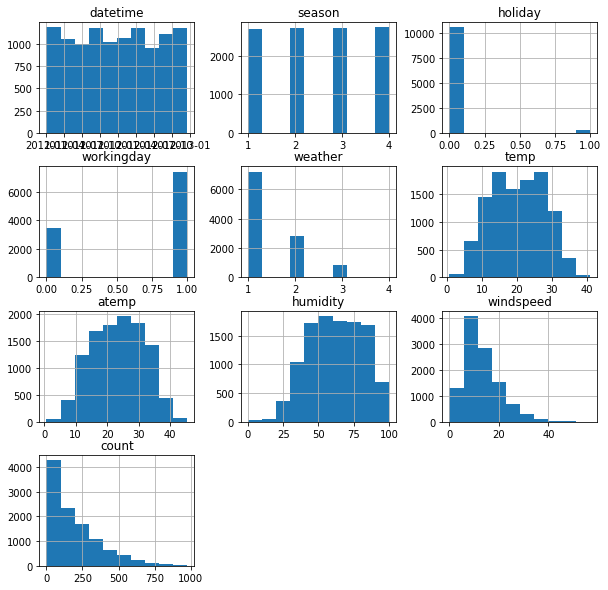

In [29]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
train.hist(ax=ax)
plt.show();

### Findings from the plot above:
- We can extract time of the day hour and month from datetime column. 
- The four seasons have are perfetly balanced with each others, there is no season more that the other.
- There are some features that needs to be with a categoey type such as "season" and "weather" .
- Our target column "count" is right-skewed, it ranges from 0 to almost 1000, but the values are centered under 250.


In [30]:
# create a new features from datetime on train dataset
train["hour"] = train["datetime"].dt.hour
train["day"] = train["datetime"].dt.day
train["month"] = train["datetime"].dt.month
train["day_of_week"] = train["datetime"].dt.dayofweek

# create a new features from datetime on test dataset
test["hour"] = test["datetime"].dt.hour
test["day"] = test["datetime"].dt.day
test["month"] = test["datetime"].dt.month
test["day_of_week"] = test["datetime"].dt.dayofweek

In [31]:
# Sanity check
train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,day_of_week
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1,5


## Make category types 

In [35]:
# Changing train category column
train["season"]  = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
train["holiday"] = train["holiday"].astype("category")
train["workingday"] = train["workingday"].astype("category")
train["day_of_week"] = train["day_of_week"].astype("category")

# Changing test category column
test["season"]   = test["season"] .astype("category")
test["weather"]  = test["weather"].astype("category")
test["holiday"] = test["holiday"].astype("category")
test["workingday"] = test["workingday"].astype("category")
test["day_of_week"] = test["day_of_week"].astype("category")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


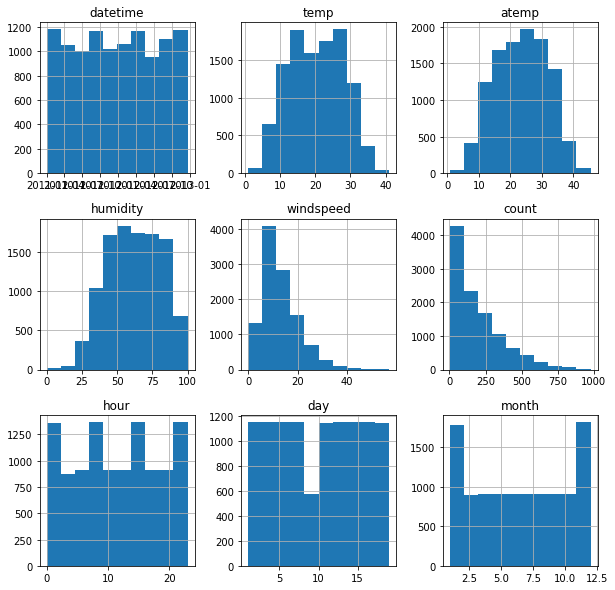

In [38]:
# View histogram of all features again now with the hour feature
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
train.hist(ax=ax)
plt.show();

## Step 5: Rerun the model with the same settings as before, just with more features

In [39]:
predictor_new_features = TabularPredictor(label="count").fit(train_data=train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20220714_182902/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220714_182902/"
AutoGluon Version:  0.5.0
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2056.86 MB
	Train Data (Original)  Memory Usage: 0.

In [40]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.231891      17.899292  537.180222                0.000888           0.452363            3       True         15
1          CatBoost_BAG_L2  -30.488228      16.362793  475.687588                0.116221          77.908857            2       True         13
2          LightGBM_BAG_L2  -30.584662      16.524412  421.872922                0.277840          24.094190            2       True         11
3        LightGBMXT_BAG_L2  -31.289412      16.891466  424.529756                0.644894          26.751024            2       True         10
4     ExtraTreesMSE_BAG_L2  -31.316966      16.859449  407.973788                0.612877          10.195057            2       True         14
5   RandomForestMSE_BAG_L2  -31.641356      16.855890  429.758265         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -33.83740573762014,
  'LightGBM_BAG_L1': -3

In [41]:
# predict on the test data set
predictions_new_features = pd.Series(predictor_new_features.predict(test))

In [42]:
# How many negative values do we have?
print("We have {} negative values".format(len(predictions_new_features[predictions_new_features < 0])))

We have 0 negative values


In [43]:
submission_new_features = submission.copy()
submission_new_features["count"] = predictions_new_features
# Set them to zero
submission_new_features["count"] = submission_new_features["count"].apply(lambda x : 0 if (x < 0 ) else x)
submission_new_features.head()

,datetime,count
0,2011-01-20 00:00:00,15.437541
1,2011-01-20 01:00:00,10.786218
2,2011-01-20 02:00:00,9.870310
3,2011-01-20 03:00:00,8.669588
4,2011-01-20 04:00:00,7.631846


In [ ]:
# Same submitting predictions
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

In [44]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2022-07-13 18:18:07  new features with hyperparameters  complete  0.45967      0.45967       
submission_new_features.csv  2022-07-13 14:34:44  new features                       complete  0.45996      0.45996       
submission.csv               2022-07-13 13:20:56  first raw submission               complete  1.78428      1.78428       
submission.csv               2022-07-12 23:00:27  first raw submission               complete  1.80657      1.80657       


#### New Score of 0.45996

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [49]:
import autogluon.core as ag

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

time_limit = 15*60  # train various models for ~2 min
num_trials = 5  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}


In [50]:
predictor_new_hpo = TabularPredictor(label="count",eval_metric="root_mean_squared_error",
                                    problem_type="regression").fit(train_data=train, time_limit=time_limit,
                                                                        presets="best_quality",
                                                                        hyperparameters=hyperparameters,
                                                                        hyperparameter_tune_kwargs=hyperparameter_tune_kwargs)

No path specified. Models will be saved in: "AutogluonModels/ag-20220714_192813/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "AutogluonModels/ag-20220714_192813/"
AutoGluon Version:  0.5.0
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1897.88 MB
	Train Data (Original)  Memory Usage: 0.75 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting Identity

In [51]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                       model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        WeightedEnsemble_L3  -35.868756       3.273731  426.254722                0.001174           0.605465            3       True         19
1         LightGBM_BAG_L2/T2  -36.092676       2.210027  277.895647                0.124260          17.339312            2       True         11
2         LightGBM_BAG_L2/T1  -36.255112       2.230402  277.631882                0.144635          17.075548            2       True         10
3         LightGBM_BAG_L2/T3  -36.334751       2.243874  278.166720                0.158107          17.610386            2       True         12
4         LightGBM_BAG_L2/T5  -36.793716       2.225188  278.535207                0.139421          17.978872            2       True         14
5   NeuralNetTorch_BAG_L2/T1  -37.654476       2.481736  306.2

{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T5': 'StackerEnsembleModel_LGB',
  'NeuralNetTorch_BAG_L1/T1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'NeuralNetTorch_BAG_L1/T2': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'NeuralNetTorch_BAG_L1/T3': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T5': 'StackerEnsembleModel_LGB',
  'NeuralNetTorch_BAG_L2/T1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'NeuralNetTorch_BAG_L2/T2': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'NeuralNetTorch_BAG_L2/T3': 'Stac

In [52]:
# predict on the test data set
predictions_new_hpo = pd.Series(predictor_new_hpo.predict(test))

In [53]:
# How many negative values do we have?
print("We have {} negative values".format(len(predictions_new_hpo[predictions_new_hpo < 0])))

We have 0 negative values


In [54]:
submission_new_hpo = submission.copy()
submission_new_hpo["count"] = predictions_new_hpo
# Set them to zero
submission_new_hpo["count"] = submission_new_hpo["count"].apply(lambda x : 0 if (x < 0 ) else x)
submission_new_hpo.head()

,datetime,count
0,2011-01-20 00:00:00,11.367373
1,2011-01-20 01:00:00,6.170969
2,2011-01-20 02:00:00,5.855747
3,2011-01-20 03:00:00,5.612851
4,2011-01-20 04:00:00,5.615135


In [55]:
# Same submitting predictions
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [56]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 242k/242k [00:00<00:00, 596kB/s]
Successfully submitted to Bike Sharing Demand

In [57]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2022-07-14 19:41:43  new features with hyperparameters  complete  0.46386      0.46386       
submission_new_hpo.csv       2022-07-13 18:18:07  new features with hyperparameters  complete  0.45967      0.45967       
submission_new_features.csv  2022-07-13 14:34:44  new features                       complete  0.45996      0.45996       
submission.csv               2022-07-13 13:20:56  first raw submission               complete  1.78428      1.78428       


#### New Score of 0.45967

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

In [3]:
import pandas as pd

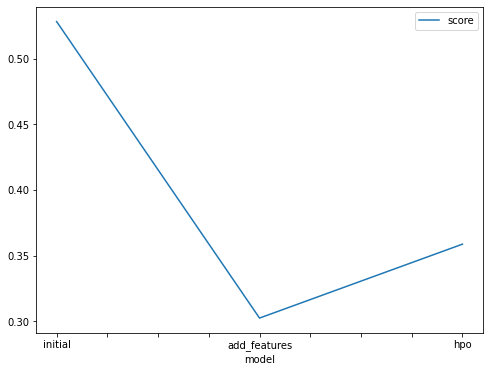

In [60]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [predictor.leaderboard(silent=True)['score_val'][0]/-100, 
                  predictor_new_features.leaderboard(silent=True)['score_val'][0]/-100, 
                  predictor_new_hpo.leaderboard(silent=True)['score_val'][0]/-100]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

In [51]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80657, 0.45996, 0.45967]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [54]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ['label', 'time_limit', 'presets'],
    "hpo2": ['label', 'time_limit', 'presets'],
    "hpo3": ['eval_metric', 'problem_typ', 'presets'],
    "score": [1.80657, 0.45996,0.45967]
})
